In [61]:
%matplotlib inline

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import ConvLSTM2D
import datetime
from math import sqrt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
import warnings

In [62]:
df = pd.read_csv('final_df_UE.csv', index_col = 'year', header = 0)

fr_co2 = df[(df['Sector'] == 'Transportation') & (df['Gas'] == 'CO2') & (df['Country'] == 'France')]
fr_co2= fr_co2.drop(['Country','Sector','Gas'], axis = 1)
fr_co2.sort_index( ascending = True, inplace = True)


# Multi-Step LSTM Models

In [63]:
# split a univariate sequence into samples with a specified number of input and output time steps
def split_sequence_in_out(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [64]:
#split our data into train and test datasets
X_train, X_test = train_test_split(fr_co2, test_size = 0.2, shuffle = False)

## Bidirectionnal multistep

In [65]:
n_steps_in = 6
n_steps_out = 2

# split X_train into samples
X, y = split_sequence_in_out(X_train, n_steps_in, n_steps_out)

In [66]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [67]:
# define model
model_Bi_mult = Sequential()
model_Bi_mult.add(Bidirectional(LSTM(60, activation='relu'), input_shape=(n_steps_in, n_features)))
model_Bi_mult.add(Dense(n_steps_out))

model_Bi_mult.compile(optimizer='adam', loss='mean_absolute_error')

# fit model
model_Bi_mult.fit(X, y, epochs= 100, verbose=0)

In [68]:
#function to calculate predictions

def calculate_predictions(model, Xinput, window):
    n_years = fr_co2.shape[0] - X.shape[0] + window
    for i in range(n_years):
        x_input = Xinput[-n_steps_in:]
        x_input = x_input.reshape((1, n_steps_in, n_features))
        y = model.predict(x_input, verbose=0)
        Xinput = np.concatenate((Xinput, np.squeeze(y)))
    
    predictions = Xinput[-window:]  
    return predictions  
        

In [69]:
Xinput = np.squeeze(X[-1])
window = 6

predictions = calculate_predictions(model_Bi_mult,Xinput, window)

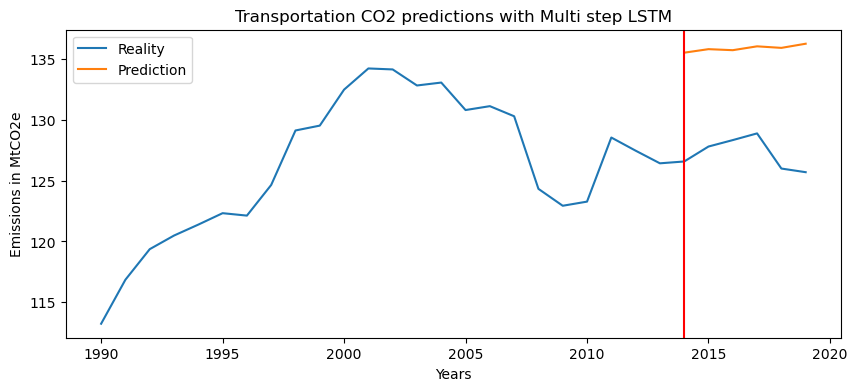

In [70]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label ='Reality')
plt.plot(range(2014,2020) , predictions ,label= 'Prediction')

plt.axvline(x=2014, color='red')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Multi step LSTM')

plt.legend()
plt.show();

In [71]:
MAE_multi_step = mean_absolute_error(X_test,predictions)
print('MAE Multi-step LSTM :',MAE_multi_step)

MAE Multi-step LSTM : 8.665134785970054


In [72]:
# training on full dataset
model_Bi_mult.reset_states()

X, y = split_sequence_in_out(fr_co2, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

model_Bi_mult.fit(X, y, epochs=100, verbose=0)

In [73]:
#making forecasts for next 10 years

Xinput = np.squeeze(X[-1])
window = 10
forecasts = calculate_predictions(model_Bi_mult,Xinput, window)

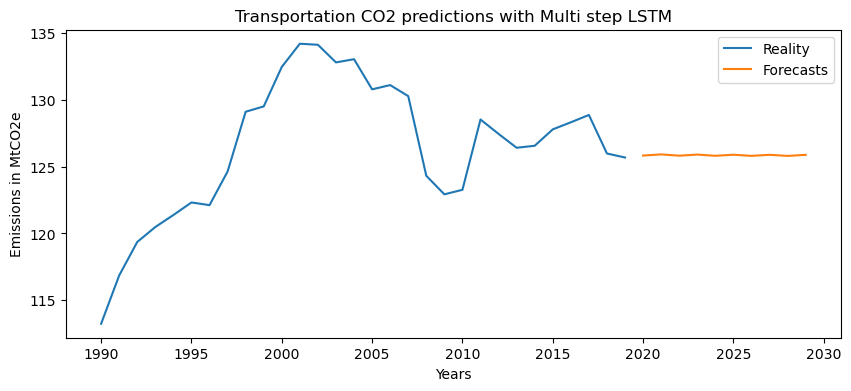

In [74]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(range(2020,2030), forecasts, label = 'Forecasts')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Multi step LSTM')

plt.legend()
plt.show()

In [75]:
model_Bi_mult.reset_states()

## Encoder-Decoder Model

In [76]:
n_steps_in = 4
n_steps_out = 2

# split X_train into samples
X, y = split_sequence_in_out(X_train, n_steps_in, n_steps_out)

In [77]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [78]:
# define model
from keras.layers import RepeatVector

enc_dec = Sequential()
enc_dec.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
enc_dec.add(RepeatVector(n_steps_out))
enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
enc_dec.add(TimeDistributed(Dense(1)))

enc_dec.compile(optimizer='adam', loss='mean_absolute_error')

In [79]:
enc_dec.fit(X, y, epochs=200, verbose=0)

In [80]:
Xinput = np.squeeze(X[-1])
window = 6

predictions = calculate_predictions(enc_dec, Xinput, window)

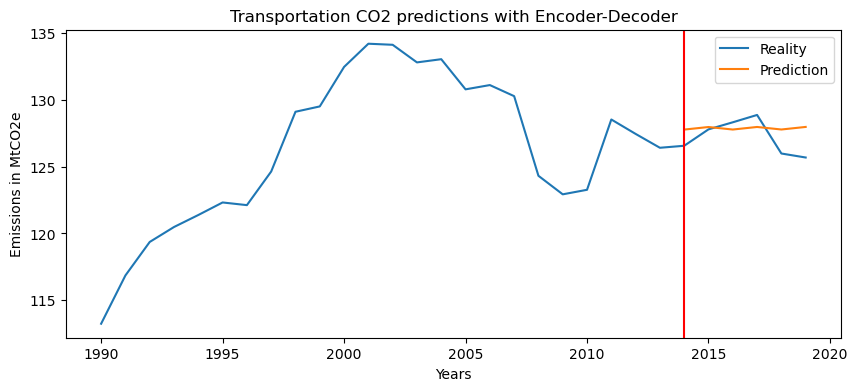

In [81]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(range(2014,2020) , predictions ,label = 'Prediction')

plt.axvline(x=2014, color='red')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Encoder-Decoder')

plt.legend()
plt.show();

In [82]:
MAE_enc_dec = mean_absolute_error(X_test, predictions)
print('MAE Encoder-Decoder :',MAE_enc_dec)

MAE Encoder-Decoder : 1.1541780090332072


In [83]:
#training on full dataset

enc_dec.reset_states()

X, y = split_sequence_in_out(fr_co2, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

enc_dec.fit(X, y, epochs=100, verbose=0)

In [84]:
#making forecasts for next 10 years

Xinput = np.squeeze(X[-1])
window = 10
forecasts = calculate_predictions(enc_dec,Xinput, window)

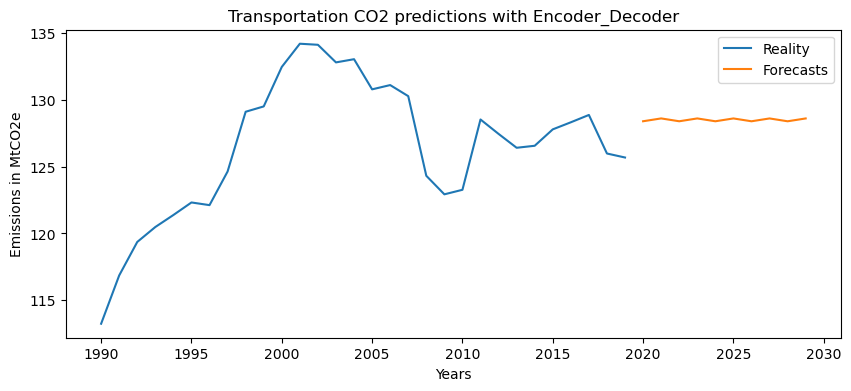

In [85]:
plt.figure(figsize = (10,4))

plt.plot(fr_co2, label='Reality')
plt.plot(range(2020,2030), forecasts, label = 'Forecasts')

plt.xlabel('Years')
plt.ylabel('Emissions in MtCO2e')
plt.title('Transportation CO2 predictions with Encoder_Decoder')

plt.legend()
plt.show()

In [86]:
enc_dec.reset_states()